# Goal 

The goal of this blog is to mainly show two different ways of implementing linear regression. First, we implement the following analytical formula
$$ \vec{w} = (X^TX)^{-1}X^Ty\,\,,$$ 
which explicitly gives a value for *$\vec{w}$*. This formula is derived using some linear algebra to solve the equation $\nabla L(\vec{w}) = 0$, which must hold at a minimum. Even though this formula provides a straightforward way to find $\vec{w}$, it is not the most efficient. Therefore, a gradient descent method is also implemented. 

The implementations can be found here: 

<https://github.com/eduparlema/eduparlema.github.io/commit/d5bea3aa7d446dbc73b9d2e9571b65ae68b1695e>

# Demo

To test our implementation, first let us write a function that produces data for us and let us visualize it: 

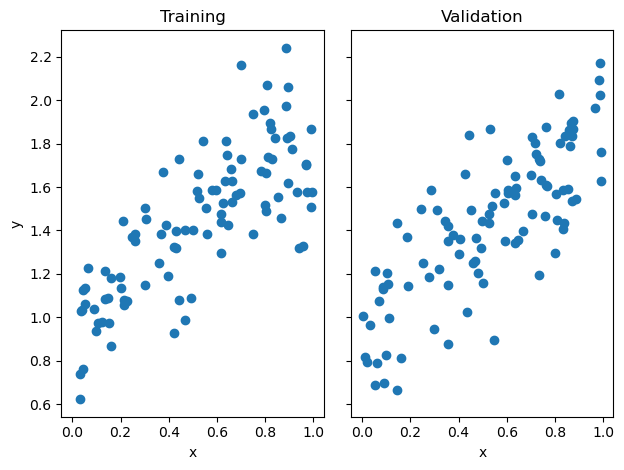

In [122]:
%reload_ext autoreload 
%autoreload 2

import numpy as np
from linearRegression import LinearRegression
from matplotlib import pyplot as plt

def pad(X):
    return np.append(X, np.ones((X.shape[0], 1)), 1)

def LR_data(n_train = 100, n_val = 100, p_features = 1, noise = .1, w = None):
    if w is None: 
        w = np.random.rand(p_features + 1) + .2
    
    X_train = np.random.rand(n_train, p_features)
    y_train = pad(X_train)@w + noise*np.random.randn(n_train)

    X_val = np.random.rand(n_val, p_features)
    y_val = pad(X_val)@w + noise*np.random.randn(n_val)
    
    return X_train, y_train, X_val, y_val

n_train = 100
n_val = 100
p_features = 1
noise = 0.2

# create some data
X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)

# plot it
fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
axarr[0].scatter(X_train, y_train)
axarr[1].scatter(X_val, y_val)
labs = axarr[0].set(title = "Training", xlabel = "x", ylabel = "y")
labs = axarr[1].set(title = "Validation", xlabel = "x")
plt.tight_layout()




Now, we print the scores and draw the lines from the resulting weights of both models implemented: 

Training score (Analytical) = 0.6114
Validation score (Analytical) = 0.6243
Training score (Gradient)= 0.5788
Validation score (Gradient) = 0.6177


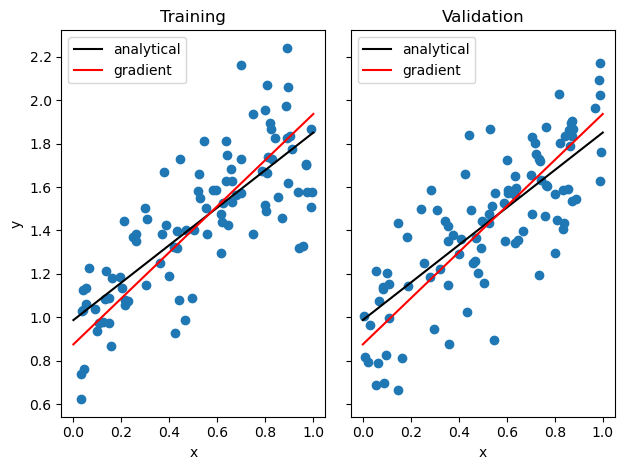

In [123]:
LR = LinearRegression()
LR.fit_analytical(X_train, y_train) # I used the analytical formula as my default fit method

print(f"Training score (Analytical) = {LR.score(X_train, y_train).round(4)}")
print(f"Validation score (Analytical) = {LR.score(X_val, y_val).round(4)}")

LR2 = LinearRegression()
LR2.fit_gradient(X_train, y_train, alpha = 0.0005) 

print(f"Training score (Gradient)= {LR2.score(X_train, y_train).round(4)}")
print(f"Validation score (Gradient) = {LR2.score(X_val, y_val).round(4)}")

#Plot both analytical and gradient descent results 
x = np.linspace(0, 1, 101)
y_analytical = (LR.w[0]*x + LR.w[1])
y_gradient = (LR2.w[0]*x + LR2.w[1])

fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
axarr[0].scatter(X_train, y_train)
axarr[1].scatter(X_val, y_val)
#print lines
axarr[0].plot(x, y_analytical, color="black", label="analytical")
axarr[1].plot(x, y_analytical, color="black", label="analytical")
axarr[0].plot(x, y_gradient, color="red", label="gradient")
axarr[1].plot(x, y_gradient, color="red", label="gradient")
axarr[0].legend(loc="best")
axarr[1].legend(loc="best")

labs = axarr[0].set(title = "Training", xlabel = "x", ylabel = "y")
labs = axarr[1].set(title = "Validation", xlabel = "x")
plt.tight_layout()


We see how both implementations lead to the similar results. The analytical formula seems to me slightly better, this is probably due to the learning rate of the gradient descent or the number of iterations. 

Now, to make sure the implementation of gradient descent is correct, let us visualize the how the score changed over time. The score should increase monotonically, and it does: 

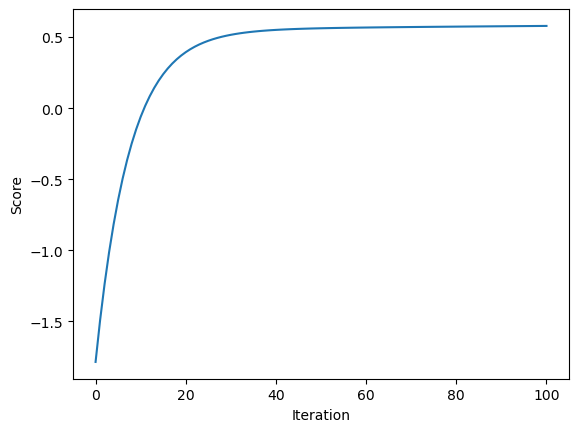

In [124]:
plt.plot(LR2.score_history)

labels = plt.gca().set(xlabel = "Iteration", ylabel = "Score")
plt.show()

# Experiment

What if we increaase the number of features? Our model would have more data points so we should expect to produce a better training score as the number of features increase. However, would this lead to overfitting? Well, let's perform an experiment that allow us to visualize the change in both the trainig and validation score. 

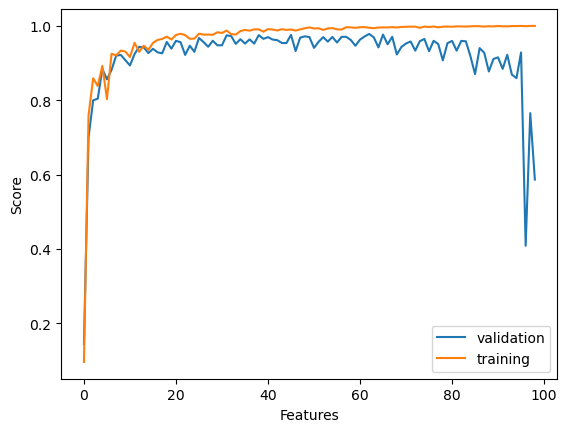

In [135]:
n_train = 100
n_val = 100
noise = 0.2

number_features = []  
validation_score = [] 
training_score = []

LR = LinearRegression()

for p_features in range(1, n_val):
    number_features.append(p_features)
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    LR.fit_analytical(X_train, y_train)
    validation_score.append(LR.score(X_val, y_val))
    training_score.append(LR.score(X_train, y_train))

plt.plot(validation_score, label = "validation")
plt.plot(training_score, label = "training")
plt.legend(loc='best')
labels = plt.gca().set(xlabel = "Features", ylabel = "Score")
plt.show()
    

Just as predicted, the training score seems to approach 1 as the numer of features increase. However, the validation score clearly decreases after some point, which suggests that increasing the number of features leads to overfitting. 

We now run the same experiment but with the LASSO algorithm. This algorithm uses a modified loss function with a regularization term $\alpha$: 

$$L(\vec{w}) = || Xw - y||^2_2 + \alpha ||\vec{w}'||_1$$

Let's visualize the experiment on LASSO with varying regularization strengths: 

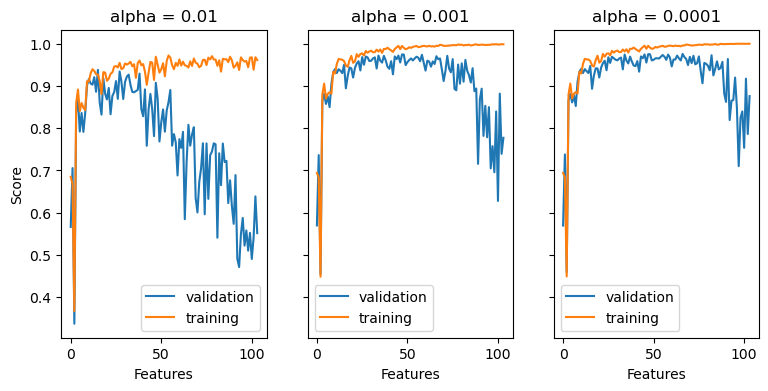

In [161]:
%%capture --no-display
from sklearn.linear_model import Lasso

number_features = []  
validation_score_1 = [] 
training_score_1 = []
validation_score_2 = [] 
training_score_2 = []
validation_score_3 = [] 
training_score_3 = []

L1 = Lasso(alpha=0.01)
L2 = Lasso(alpha=0.001)
L3 = Lasso(alpha=0.0001)

for p_features in range(1, n_val+5):
    number_features.append(p_features)
    X_train, y_train, X_val, y_val = LR_data(n_train, n_val, p_features, noise)
    L1.fit(X_train, y_train)
    validation_score_1.append(L1.score(X_val, y_val))
    training_score_1.append(L1.score(X_train, y_train))
    L2.fit(X_train, y_train)
    validation_score_2.append(L2.score(X_val, y_val))
    training_score_2.append(L2.score(X_train, y_train))
    L3.fit(X_train, y_train)
    validation_score_3.append(L3.score(X_val, y_val))
    training_score_3.append(L3.score(X_train, y_train))

fig, axarr = plt.subplots(1, 3, sharex = True, sharey = True)

axarr[0].plot(validation_score_1, label = "validation")
axarr[0].plot(training_score_1, label = "training")
axarr[0].legend(loc='best')

axarr[1].plot(validation_score_2, label = "validation")
axarr[1].plot(training_score_2, label = "training")
axarr[1].legend(loc='best')

axarr[2].plot(validation_score_3, label = "validation")
axarr[2].plot(training_score_3, label = "training")
axarr[2].legend(loc='best')

labs = axarr[0].set(title = "alpha = 0.01", xlabel = "Features", ylabel = "Score")
labs = axarr[1].set(title = "alpha = 0.001", xlabel = "Features")
labs = axarr[2].set(title = "alpha = 0.0001", xlabel = "Features")
fig.set_size_inches(9, 4, forward=True)


We observe that the LASSO algorithm reaches a better accuracy than the regular linear regression, as it quickly gets close to 1. However, we observe the same overfitting trend. The regularization strenght seems to affect how the validation score drops, a smaller alpha seems to be better for overfitted models. 